# Question 1:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve

# a.read data


In [2]:
file=pd.read_csv(
    'Homework 6 Data/wdbc.data', names=['id','label','mean_radius',
    'mean_texture','mean_perimeter','mean_area','mean_smoothness',
    'mean_compactness','mean_concavity','mean_concave points',
    'mean_symmetry','mean_fractal dimension','std_radius',
    'std_texture','std_perimeter','std_area','std_smoothness',
    'std_compactness','std_concavity','std_concave points',
    'std_symmetry','std_fractal dimension','largest_radius',
    'largest_texture','largest_perimeter','largest_area',
    'largest_smoothness','largest_compactness',
    'largest_concavity','largest_concave points',
    'largest_symmetry','largest_fractal dimension']
    )
file_m=file.loc[file['label']=='M'].sample(frac=0.2,axis=0)
file_b=file.loc[file['label']=='B'].sample(frac=0.2,axis=0)
testdata=pd.concat([file_m,file_b])
traindata=file.drop(index=testdata.index)
testdata=testdata.replace('M',1)
testdata=testdata.replace('B',0)
traindata=traindata.replace('M',1)
traindata=traindata.replace('B',0)

# b(1). Monte-Carlo simulation, Supervised

In [3]:
x_testdata_nor = preprocessing.normalize(testdata.iloc[:,2:])
x_traindata_nor = preprocessing.normalize(traindata.iloc[:,2:])

avg_accuracy = 0.9734513274336284
avg_precision = 1.0
avg_recall = 0.9285714285714283
avg_f1_score = 0.9629629629629629
avg_auc = 0.9642857142857145
--Confusion Matrix for the 30th test--
[[71  0]
 [ 3 39]]


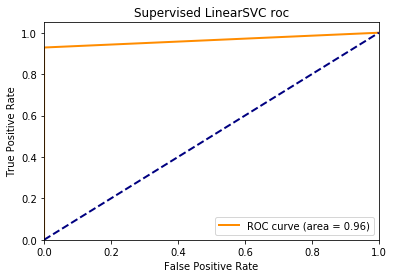

In [4]:
accuracy_set = []
precision_set = []
recall_set = []
f1_score_set = []
auc_set = []
M = np.arange(1,31,1)

for m in M:
    c_set = np.logspace(-2, 5, 9)
    scores_set = {}
    for c in c_set:
        scv = LinearSVC(penalty='l1', random_state=42+m, C=c, dual=False) 
        scores = cross_val_score(scv, x_traindata_nor, y=traindata[['label']],cv=5).mean()
        scores_set[c] = scores
    best_c = max(scores_set.keys(),key=(lambda x:scores_set[x]))

    scv = LinearSVC(penalty='l1', random_state=42+m, dual=False, C=best_c)
    scv.fit(x_traindata_nor, traindata[['label']])
    y_pred = scv.predict(x_testdata_nor)

    accuracy_set.append(accuracy_score(np.array(testdata[['label']]),y_pred))
    precision_set.append(precision_score(np.array(testdata[['label']]),y_pred))
    recall_set.append(recall_score(np.array(testdata[['label']]),y_pred))
    f1_score_set.append(f1_score(np.array(testdata[['label']]),y_pred))
    fpr, tpr, thresholds = roc_curve(np.array(testdata[['label']]),y_pred)
    auc_set.append(auc(fpr,tpr))

print('avg_accuracy =',np.mean(accuracy_set))
print('avg_precision =',np.mean(precision_set))
print('avg_recall =',np.mean(recall_set))
print('avg_f1_score =',np.mean(f1_score_set))
print('avg_auc =',np.mean(auc_set))
print('--Confusion Matrix for the 30th test--')
print(confusion_matrix(np.array(testdata[['label']]), y_pred))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Supervised LinearSVC roc')
plt.legend(loc="lower right")
plt.show()

# b(2). Monte-Carlo simulation, Semi-Supervised

In [5]:
file_m=traindata.loc[traindata['label']==1]
file_b=traindata.loc[traindata['label']==0]
l_m=file_m.sample(frac=0.5, random_state=42 ,axis=0)
l_b=file_b.sample(frac=0.5, random_state=42 ,axis=0)
u_m=file_m.drop(index=l_m.index)
u_b=file_b.drop(index=l_b.index)
l_train=pd.concat([l_m,l_b])
u_train=pd.concat([u_m,u_b])

l_nor = pd.DataFrame(preprocessing.normalize(l_train.iloc[:,2:]))
u_nor = preprocessing.normalize(u_train.iloc[:,2:])

accuracy_set = []
precision_set = []
recall_set = []
f1_score_set = []
auc_set = []
M = np.arange(1,31,1)

avg_accuracy = 0.9646017699115041
avg_precision = 1.0
avg_recall = 0.9047619047619049
avg_f1_score = 0.9499999999999998
avg_auc = 0.9523809523809523
--Confusion Matrix for the 30th test--
[[71  0]
 [ 4 38]]


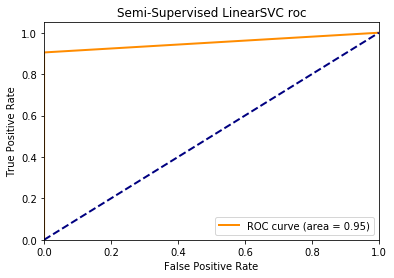

In [6]:
l_label = l_train[['label']]
for m in M:
    c_set = np.logspace(-2, 5, 9)
    scores_set = {}
    for c in c_set:
        scv = LinearSVC(penalty='l1', random_state=42+m, C=c, dual=False) 
        scores = cross_val_score(scv, l_nor, y=l_label,cv=5).mean()
        scores_set[c] = scores
    best_c = max(scores_set.keys(),key=(lambda x:scores_set[x]))
    scv = LinearSVC(penalty='l1', random_state=42+m, dual=False, C=best_c)
    scv.fit(l_nor, l_label)
# put the farthest unlabeled data into labeled set
    while len(u_nor) > 0:
        distance_set=list(scv.decision_function(u_nor))
        u_pred=scv.predict(u_nor)
        farthest_u=distance_set.index(max(distance_set))
        l_nor.append(pd.Series(u_nor[farthest_u]),ignore_index=True)
        l_label.append(pd.Series(u_pred),ignore_index=True)
        u_nor=np.delete(u_nor, farthest_u , 0)
# retrain the svm model
        scores_set = {}
        for c in c_set:
            scv = LinearSVC(penalty='l1', random_state=42+m, C=c, dual=False) 
            scores = cross_val_score(scv, l_nor, y=l_label,cv=5).mean()
            scores_set[c] = scores
        best_c = max(scores_set.keys(),key=(lambda x:scores_set[x]))
        scv = LinearSVC(penalty='l1', random_state=42+m, dual=False, C=best_c)
        scv.fit(l_nor, l_label)
# predict on test set            
    y_pred = scv.predict(x_testdata_nor)
    accuracy_set.append(accuracy_score(np.array(testdata[['label']]),y_pred))
    precision_set.append(precision_score(np.array(testdata[['label']]),y_pred))
    recall_set.append(recall_score(np.array(testdata[['label']]),y_pred))
    f1_score_set.append(f1_score(np.array(testdata[['label']]),y_pred))
    fpr, tpr, thresholds = roc_curve(np.array(testdata[['label']]),y_pred)
    auc_set.append(auc(fpr,tpr))
# show the result        
print('avg_accuracy =',np.mean(accuracy_set))
print('avg_precision =',np.mean(precision_set))
print('avg_recall =',np.mean(recall_set))
print('avg_f1_score =',np.mean(f1_score_set))
print('avg_auc =',np.mean(auc_set))
print('--Confusion Matrix for the 30th test--')
print(confusion_matrix(np.array(testdata[['label']]), y_pred))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Semi-Supervised LinearSVC roc')
plt.legend(loc="lower right")
plt.show()

# b(3).b. Monte-Carlo simulation, Unsupervised

In [7]:
x_traindata=traindata.iloc[:,2:]
x_testdata=testdata.iloc[:,2:]
accuracy_set = []
precision_set = []
recall_set = []
f1_score_set = []
auc_set = []

M = np.arange(1,31,1)

avg_accuracy = 0.8552631578947367
avg_precision = 0.9905660377358492
avg_recall = 0.6176470588235293
avg_f1_score = 0.7608695652173912
avg_auc = 0.8070752776635133
--Confusion Matrix for the 30th test--
[[285   1]
 [ 65 105]]


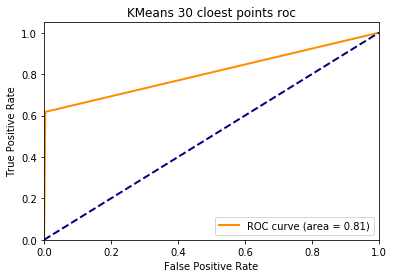

In [8]:
for m in M:
    scv = KMeans(n_clusters=2,random_state=42+m)
    scv.fit(x_traindata)
# determine the label of predicted instance:
    distance_set0 = {}
    distance_set1 = {}
    vote_set0 = []
    vote_set1 = []
    index0 = []
    index1 = []
    y_pred = []
    for i in range(len(x_traindata)):
        distance0 = np.linalg.norm(np.array(x_traindata.iloc[i])-scv.cluster_centers_[0])
        distance1 = np.linalg.norm(np.array(x_traindata.iloc[i])-scv.cluster_centers_[1])
        if distance0 < distance1:
            distance_set0[i,int(traindata.iloc[i].iat[1])] = distance0
        else:
            distance_set1[i,int(traindata.iloc[i].iat[1])] = distance1
    
    top0=sorted(distance_set0.items(), key=lambda d: d[1])
    top1=sorted(distance_set1.items(), key=lambda d: d[1])
    for i in range(len(top0)):
        index0.append(top0[i][0][0])
    for i in range(len(top1)):
        index1.append(top1[i][0][0])
    for i in range(0,31):
        vote_set0.append(top0[i][0][1])
        vote_set1.append(top1[i][0][1])
    if sum(vote_set0)>=15:
        vote0 = 1
    else:
        vote0 = 0
    if sum(vote_set1)>=15:
        vote1 = 1
    else:
        vote1 = 0
    for i in range(len(x_traindata)):
        if i in index0:
            y_pred.append(vote0)
        else:
            y_pred.append(vote1)
# calculate evaluation scores
    accuracy_set.append(accuracy_score(np.array(traindata[['label']]),y_pred))
    precision_set.append(precision_score(np.array(traindata[['label']]),y_pred))
    recall_set.append(recall_score(np.array(traindata[['label']]),y_pred))
    f1_score_set.append(f1_score(np.array(traindata[['label']]),y_pred))
    fpr, tpr, thresholds = roc_curve(np.array(traindata[['label']]),y_pred)
    auc_set.append(auc(fpr,tpr))

# show the result        
print('avg_accuracy =',np.mean(accuracy_set))
print('avg_precision =',np.mean(precision_set))
print('avg_recall =',np.mean(recall_set))
print('avg_f1_score =',np.mean(f1_score_set))
print('avg_auc =',np.mean(auc_set))
print('--Confusion Matrix for the 30th test--')
print(confusion_matrix(np.array(traindata[['label']]), y_pred))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KMeans 30 cloest points roc')
plt.legend(loc="lower right")
plt.show()

# b(3).c. Monte-Carlo simulation, Unsupervised

avg_accuracy = 0.849557522123894
avg_precision = 1.0
avg_recall = 0.5952380952380951
avg_f1_score = 0.7462686567164176
avg_auc = 0.7976190476190477
--Confusion Matrix for the 30th test--
[[71  0]
 [17 25]]


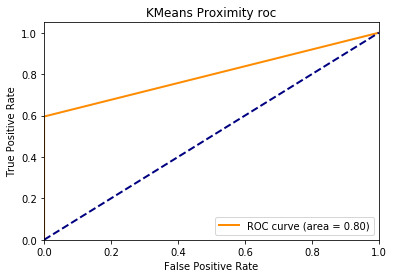

In [9]:
accuracy_set = []
precision_set = []
recall_set = []
f1_score_set = []
auc_set = []


M = np.arange(1,31,1)

for m in M:
    scv = KMeans(n_clusters=2,random_state=42+m)
    scv.fit(x_traindata)
    label = scv.predict(x_testdata)
    
    vote_set0 = []
    vote_set1 = []
    y_pred = []   
    for i in range(len(label)):
        if label[i] == 1:
            vote_set1.append(int(testdata.iloc[i].iat[1]))
        else:
            vote_set0.append(int(testdata.iloc[i].iat[1]))
    if np.mean(vote_set0)>=0.5:
        vote0 = 1
    else:
        vote0 = 0
    if np.mean(vote_set1)>=0.5:
        vote1 = 1
    else:
        vote1 = 0
    for i in range(len(label)):
        if label[i] == 0:
            y_pred.append(vote0)
        else:
            y_pred.append(vote1)

# predict on test set            
    accuracy_set.append(accuracy_score(np.array(testdata[['label']]),y_pred))
    precision_set.append(precision_score(np.array(testdata[['label']]),y_pred))
    recall_set.append(recall_score(np.array(testdata[['label']]),y_pred))
    f1_score_set.append(f1_score(np.array(testdata[['label']]),y_pred))
    fpr, tpr, thresholds = roc_curve(np.array(testdata[['label']]),y_pred)
    auc_set.append(auc(fpr,tpr))
# show the result        
print('avg_accuracy =',np.mean(accuracy_set))
print('avg_precision =',np.mean(precision_set))
print('avg_recall =',np.mean(recall_set))
print('avg_f1_score =',np.mean(f1_score_set))
print('avg_auc =',np.mean(auc_set))
print('--Confusion Matrix for the 30th test--')
print(confusion_matrix(np.array(testdata[['label']]), y_pred))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KMeans Proximity roc')
plt.legend(loc="lower right")
plt.show()

# b(4). Spectral clusting

avg_accuracy = 0.8672566371681413
avg_precision = 1.0
avg_recall = 0.6428571428571428
avg_f1_score = 0.7826086956521743
avg_auc = 0.8214285714285717
--Confusion Matrix for the 30th test--
[[71  0]
 [15 27]]


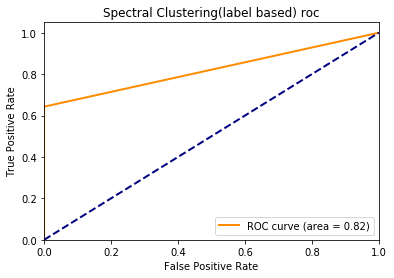

In [10]:
accuracy_set = []
precision_set = []
recall_set = []
f1_score_set = []
auc_set = []

M = np.arange(1,31,1)

for m in M:
    scv = SpectralClustering(n_clusters=2,random_state=42+m,gamma=1,affinity='rbf')
    scv.fit(x_traindata_nor)
    label = scv.fit_predict(x_testdata_nor)
    
    vote_set0 = []
    vote_set1 = []
    y_pred = []   
    for i in range(len(label)):
        if label[i] == 1:
            vote_set1.append(int(testdata.iloc[i].iat[1]))
        else:
            vote_set0.append(int(testdata.iloc[i].iat[1]))
    if np.mean(vote_set0)>=0.5:
        vote0 = 1
    else:
        vote0 = 0
    if np.mean(vote_set1)>=0.5:
        vote1 = 1
    else:
        vote1 = 0
    for i in range(len(label)):
        if label[i] == 0:
            y_pred.append(vote0)
        else:
            y_pred.append(vote1)

# predict on test set            
    accuracy_set.append(accuracy_score(np.array(testdata[['label']]),y_pred))
    precision_set.append(precision_score(np.array(testdata[['label']]),y_pred))
    recall_set.append(recall_score(np.array(testdata[['label']]),y_pred))
    f1_score_set.append(f1_score(np.array(testdata[['label']]),y_pred))
    fpr, tpr, thresholds = roc_curve(np.array(testdata[['label']]),y_pred)
    auc_set.append(auc(fpr,tpr))
# show the result        
print('avg_accuracy =',np.mean(accuracy_set))
print('avg_precision =',np.mean(precision_set))
print('avg_recall =',np.mean(recall_set))
print('avg_f1_score =',np.mean(f1_score_set))
print('avg_auc =',np.mean(auc_set))
print('--Confusion Matrix for the 30th test--')
print(confusion_matrix(np.array(testdata[['label']]), y_pred))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Spectral Clustering(label based) roc')
plt.legend(loc="lower right")
plt.show()

# b(5). Compare the result form above methods

In [13]:
results = pd.read_csv('compare.csv')
results

,Avg value,Supervised LinearSVC,Semi-Supervised LinearSVC,KMeans 30 cloest points,KMeans Proximity,Spectral Clustering(label based)
0,accuracy,0.973451,0.964602,0.855263,0.849558,0.867257
1,precision,1.000000,1.000000,0.990566,1.000000,1.000000
2,recall,0.928571,0.904762,0.617647,0.595238,0.642857
3,F-score,0.962963,0.950000,0.760870,0.746269,0.782609
4,auc,0.964286,0.952381,0.807075,0.797619,0.821429


From the results we have from previous models, the best model is supervised LinearSVC, it performs a little better than semi-supervised LinearSVC. 3 unsupervised methods seem to be much worse than those 2 svm models, the spectral clustering performs better in these 3.

# Question2:

# a.read data

In [14]:
file = pd.read_csv('Homework 6 Data/data_banknote_authentication.txt',names={'0','a','d','b','c'})
testdata=file.sample(n=472,random_state=42 ,axis=0)
traindata=file.drop(index=testdata.index)
testdata=testdata.reset_index(drop=True)
traindata=traindata.reset_index(drop=True)
testdata

,c,0,b,d,a
0,1.569100,6.346500,-0.18280,-2.409900,0
1,-0.278020,8.188100,-3.13380,-2.527600,0
2,0.051979,7.052100,-2.05410,-3.150800,0
3,-1.755900,11.945900,3.09460,-4.897800,0
4,2.428700,9.382100,-3.24770,-1.454300,0
5,4.635200,-3.008700,2.67730,1.212000,0
6,0.248350,7.643900,0.98850,-0.873710,0
7,5.173100,3.960600,-1.98300,0.407740,0
8,4.004700,0.459370,1.36210,1.618100,0
9,0.964410,5.839500,2.32350,0.066365,0


# b(1). Passive SVM

In [15]:
x_testdata_nor = pd.DataFrame(preprocessing.normalize(testdata.iloc[:,:-1]))
testdata_nor = pd.concat([x_testdata_nor, testdata[['0']]],axis=1)
x_traindata_nor = pd.DataFrame(preprocessing.normalize(traindata.iloc[:,:-1]))
traindata_nor = pd.concat([x_traindata_nor, traindata[['0']]],axis=1)


In [17]:
M = np.arange(1,51,1)
col={}
for m in M:
    row={}
    traindata_nor = pd.concat([x_traindata_nor, traindata[['a']]],axis=1)   
    x_train = pd.DataFrame()
    y_train = list()
    pop=traindata_nor.sample(n=10, random_state=42, axis=0)
    traindata_nor.drop(index=pop.index, inplace=True)
    x_train=x_train.append(pop.iloc[:,:-1])
    y_train=y_train+pop.iloc[:,-1].values.tolist()
# randomly select 10 more data
    for i in range(0,89):
        pop10=traindata_nor.sample(n=10, random_state=42+i, axis=0)
        traindata_nor.drop(index=pop10.index, inplace=True)
        x_train=x_train.append(pop10.iloc[:,:-1])
        y_train=y_train+pop10.iloc[:,-1].values.tolist()
        
        c_set = np.logspace(-2, 4, 6)
        scores_set = {}
        for c in c_set:
            scv = LinearSVC(penalty='l1', random_state=42+m, C=c, dual=False) 
            scores = cross_val_score(scv, x_train, y=y_train,cv=10).mean()
            scores_set[c] = scores
        best_c = max(scores_set.keys(),key=(lambda x:scores_set[x]))
# get accuracy
        scv = LinearSVC(penalty='l1', random_state=42+m, dual=False, C=best_c)
        scv.fit(x_train, y_train)
        y_pred = scv.predict(x_testdata_nor)
        acc=accuracy_score(np.array(testdata[['a']]),y_pred)
        row[i]=1-acc
    col[m]=row
err_passive=pd.DataFrame(col)

In [18]:
err_passive

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
1,0.027542,0.027542,0.027542,0.027542,0.027542,0.027542,0.027542,0.027542,0.027542,0.027542,...,0.027542,0.027542,0.027542,0.027542,0.027542,0.027542,0.027542,0.027542,0.027542,0.027542
2,0.050847,0.050847,0.050847,0.050847,0.050847,0.050847,0.050847,0.050847,0.050847,0.050847,...,0.050847,0.050847,0.050847,0.050847,0.050847,0.050847,0.050847,0.050847,0.050847,0.050847
3,0.025424,0.027542,0.042373,0.040254,0.027542,0.025424,0.027542,0.042373,0.025424,0.027542,...,0.027542,0.027542,0.025424,0.025424,0.042373,0.027542,0.025424,0.042373,0.025424,0.025424
4,0.063559,0.063559,0.063559,0.063559,0.063559,0.063559,0.063559,0.063559,0.063559,0.063559,...,0.063559,0.063559,0.063559,0.063559,0.063559,0.063559,0.063559,0.063559,0.063559,0.063559
5,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,...,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712
6,0.004237,0.004237,0.004237,0.004237,0.004237,0.004237,0.004237,0.004237,0.004237,0.004237,...,0.004237,0.004237,0.004237,0.004237,0.004237,0.004237,0.004237,0.004237,0.004237,0.004237
7,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
8,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
9,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593


# b(2). Active SVM

In [23]:
M = np.arange(1,51,1)
col={}
for m in M:
# create initial sets
    traindata_nor = pd.concat([x_traindata_nor, traindata[['a']]],axis=1)
    row={}
    x_train = pd.DataFrame()
    y_train = list()
    pop=traindata_nor.sample(n=10, random_state=42, axis=0)
    traindata_nor.drop(index=pop.index, inplace=True)
    traindata_nor=traindata_nor.reset_index(drop=True)
    x_train=x_train.append(pop.iloc[:,:-1])
    y_train=y_train+pop.iloc[:,-1].values.tolist()
    
    scv = LinearSVC(penalty='l1', random_state=42+m,dual=False)
    scv.fit(x_train, y_train)
    for i in range(0,89):
# add 10 cloest data    
        pop10=abs(scv.decision_function(traindata_nor.drop(['a'], axis=1))).argsort()[:10]
        for p in range(len(pop10)):
            x_train=x_train.append(x_traindata_nor.iloc[pop10[p]])
            y_train=y_train+traindata[['a']].iloc[pop10[p]].values.tolist()
        traindata_nor.drop(index=pop10, inplace=True)
        traindata_nor=traindata_nor.reset_index(drop=True)
# choose best c        
        c_set = np.logspace(-2, 4, 6)
        scores_set = {}
        for c in c_set:
            scv = LinearSVC(penalty='l1', random_state=42+m, C=c, dual=False) 
            scores = cross_val_score(scv, x_train, y=y_train,cv=10).mean()
            scores_set[c] = scores
        best_c = max(scores_set.keys(),key=(lambda x:scores_set[x]))
# get accuracy
        scv = LinearSVC(penalty='l1', random_state=42+m, dual=False, C=best_c)
        scv.fit(x_train, y_train)
        y_pred = scv.predict(x_testdata_nor)
        acc=accuracy_score(np.array(testdata[['a']]),y_pred)
        row[i]=1-acc
    col[m]=row
err_active=pd.DataFrame(col)

In [24]:
err_active

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,...,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831
1,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,...,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712
2,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
3,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
4,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
5,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
6,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
7,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
8,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
9,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356


# c. monte-carlo simulation and plot the avg-error

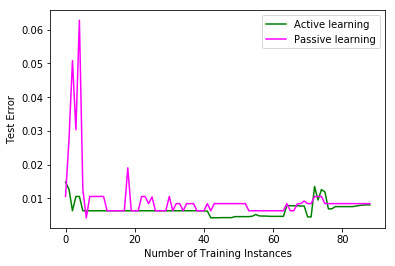

In [25]:
x = [i for i in range(0,89)]
y_passive = err_passive.mean(1)
y_active = err_active.mean(1)
plt.xlabel('Number of Training Instances')
plt.ylabel('Test Error')
plt.plot(x, y_active, 'green', label="Active learning")
plt.plot(x, y_passive, 'magenta', label="Passive learning")
plt.legend()
plt.show()

From the figure we can see that when instance is high, passive learning and active learning seems to have similiar result. However, when we only have very few samples in our dataset, active learning performs much better than passive learning.